In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md
from tqdm import tqdm
from PIL import Image

This is a one millsecond trajectory of ubiquitin generated from DEShaw Research:

https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.6b02024

Trajectory from DESRES can be downloaded here:
https://www.dropbox.com/s/qk4winh3y66bynm/ubq.desres.s500.zip?dl=0

It can be compared to an NMR ensmeble:
https://www.wwpdb.org/pdb?id=pdb_00002kox

In [2]:
pdb='/ipynb_files/CHEM96_06/Project_3/ubq.pdb'
trajectory='/ipynb_files/CHEM96_06/Project_3/ubq.desres.s500.dcd'
outdir='/ipynb_files/CHEM96_06/Project_3/outdir'

if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: /ipynb_files/CHEM96_06/Project_3/outdir
pdb: /ipynb_files/CHEM96_06/Project_3/ubq.pdb
trjaectory: /ipynb_files/CHEM96_06/Project_3/ubq.desres.s500.dcd


In [3]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [37]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 1231

Number of residues: 76

Number of frames: 10088

Starting frame: 0

Last frame: 10088

sequence:  [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]

residue names:  ['MET', 'GLN', 'ILE', 'PHE', 'VAL', 'LYS', 'THR', 'LEU', 'THR', 'GLY', 'LYS', 'THR', 'ILE', 'THR', 'LEU', 'GLU', 'VAL', 'GLU', 'PRO', 'SER', 'ASP', 'THR', 'ILE', 'GLU', 'ASN', 'VAL', 'LYS', 'ALA', 'LYS', 'ILE', 'GLN', 'ASP', 'LYS', 'GLU', 'GLY', 'ILE', 'PRO', 'PRO', 'ASP', 'GLN', 'GLN', 'ARG', 'LEU', 'ILE', 'PHE', 'AL

NameError: name 'size' is not defined

In [5]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76])

In [6]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ...,
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C']], dtype='<U2')

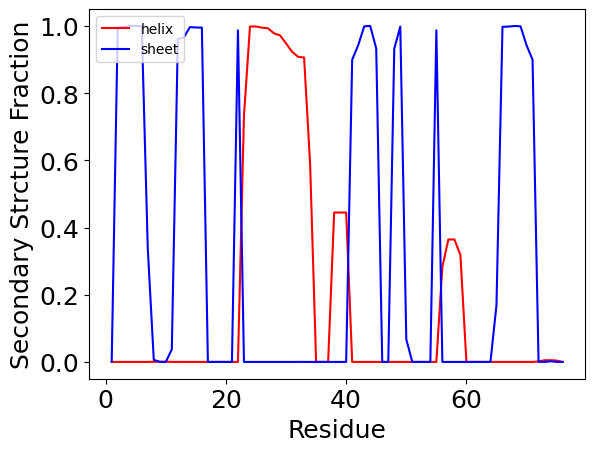

In [7]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [24 25 26 27 28 29 30 31 32 33]
SS: E [ 2  3  4  5  6 12 13 14 15 16 42 43 44 45 48 49 66 67 68 69 70]
SS: I []
SS: G []
SS: B [22 55]
SS: T [19 20 46 47 52 53 60 63 64]
SS: S []
SS:   [ 1 11 17 18 35 36 37 50 51 61 62 72 76]


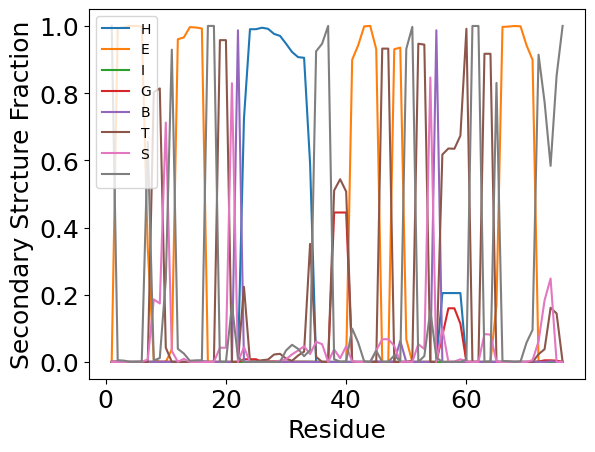

In [8]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1                                                                                      
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [9]:
#Find all the frames where a given residue is H or E
residue_number=39
array_index=residue_number-0
print(np.asarray(residue_num)[array_index])
helix_frames=np.where(dssp[:,array_index]=='H')[0]
beta_frames=np.where(dssp[:,array_index]=='E')[0]

print("Residue %s"%np.asarray(residue_num)[array_index])
print("helix frames:",len(helix_frames),helix_frames)
print("beta frames:",len(beta_frames),beta_frames)

40
Residue 40
helix frames: 4486 [    2     3     4 ... 10085 10086 10087]
beta frames: 1 [4609]


In [10]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [41]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [85]:
# print(dihedral_dict)

In [13]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




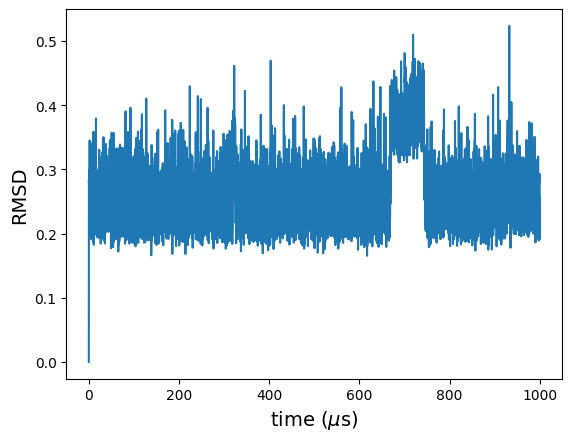

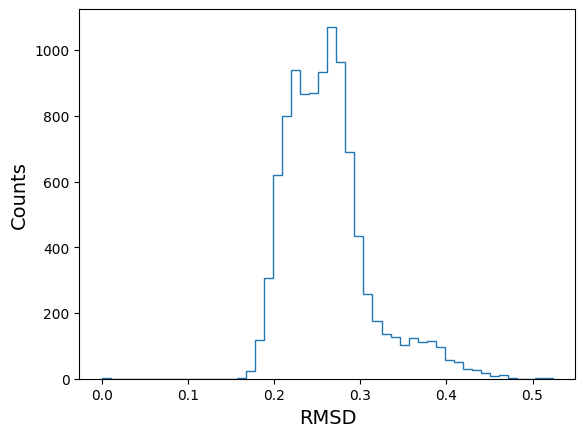

In [14]:
#Lets Calculate the RMSD and make a histogram from the starting structure 
time=np.linspace(0,1000,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

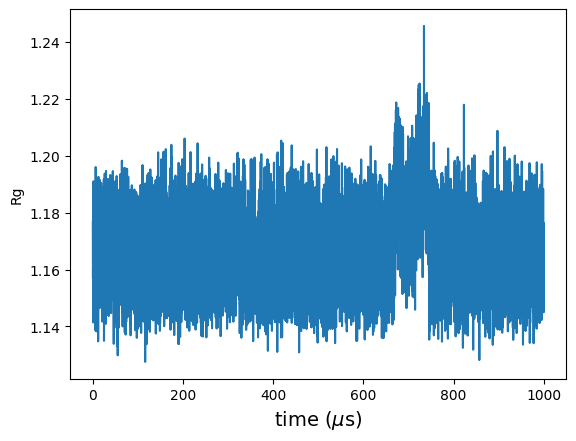

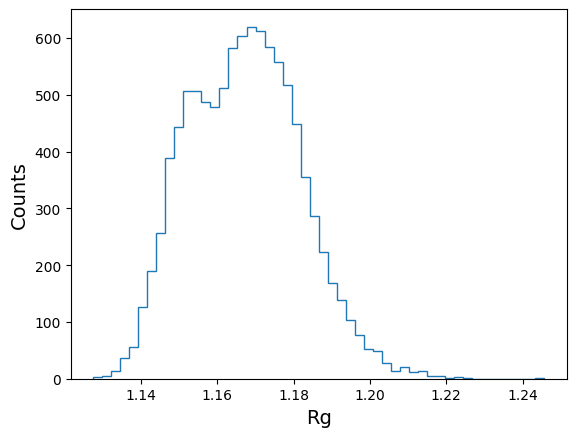

In [15]:
#Lets calculate the radius of gyration and make a histogram
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

In [16]:
#Lets identify subtantially populated hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))
    

MET1-N -- VAL17-O
MET1-N -- VAL17-O
MET1-N -- VAL17-O
ILE3-N -- LEU15-O
PHE4-N -- SER65-O
VAL5-N -- ILE13-O
LYS6-N -- LEU67-O
THR7-N -- LYS11-O
LEU8-N -- THR7-OG1
LEU8-N -- LEU69-O
THR9-N -- THR7-OG1
GLY10-N -- THR7-O
LYS11-N -- THR7-OG1
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
ILE13-N -- VAL5-O
LEU15-N -- ILE3-O
VAL17-N -- MET1-O
GLU18-N -- ASP21-OD1
GLU18-N -- ASP21-OD2
ASP21-N -- GLU18-O
THR22-N -- ASN25-OD1
ILE23-N -- ARG54-O
GLU24-N -- ASP52-O
ASN25-N -- THR22-OG1
ASN25-N -- THR22-O
ASN25-ND2 -- THR22-OG1
ASN25-ND2 -- THR22-OG1
VAL26-N -- THR22-O
VAL26-N -- ILE23-O
LYS27-N -- ILE23-O
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
ALA28-N -- GLU24-O
LYS29-N -- ASN25-O
LYS29-N -- VAL26-O
ILE30-N -- VAL26-O
ILE30-N -- LYS27-O
GLN31-N -- LYS27-O
ASP32-N

In [17]:
for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[  0   1 285] MET1-N VAL17-O
[  0   2 285] MET1-N VAL17-O
[  0   3 285] MET1-N VAL17-O
[ 36  37 254] ILE3-N LEU15-O
[  55   56 1044] PHE4-N SER65-O
[ 75  76 221] VAL5-N ILE13-O
[  91   92 1077] LYS6-N LEU67-O
[113 114 188] THR7-N LYS11-O
[127 128 119] LEU8-N THR7-OG1
[ 127  128 1113] LEU8-N LEU69-O
[146 147 119] THR9-N THR7-OG1
[160 161 126] GLY10-N THR7-O
[167 168 119] LYS11-N THR7-OG1
[183 184 551] LYS11-NZ GLU34-OE1
[183 184 552] LYS11-NZ GLU34-OE2
[183 185 551] LYS11-NZ GLU34-OE1
[183 185 552] LYS11-NZ GLU34-OE2
[183 186 551] LYS11-NZ GLU34-OE1
[183 186 552] LYS11-NZ GLU34-OE2
[203 204  90] ILE13-N VAL5-O
[236 237  54] LEU15-N ILE3-O
[270 271  18] VAL17-N MET1-O
[286 287 334] GLU18-N ASP21-OD1
[286 287 335] GLU18-N ASP21-OD2
[326 327 300] ASP21-N GLU18-O
[338 339 394] THR22-N ASN25-OD1
[352 353 869] ILE23-N ARG54-O
[371 372 838] GLU24-N ASP52-O
[386 387 344] ASN25-N THR22-OG1
[386 387 351] ASN25-N THR22-O
[395 396 344] ASN25-ND2 THR22-OG1
[395 397 344] ASN25-ND2 THR22-OG1
[400 401 

[  55   56 1044] PHE4-N SER65-O


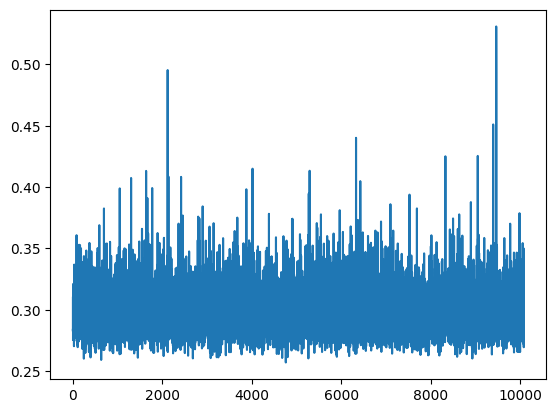

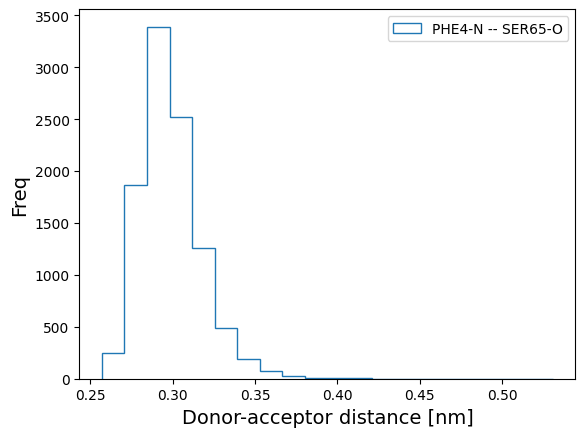

In [18]:
Hbond_index=4
hbond=hbonds[Hbond_index]
donor = top.atom(hbond[0])
acc = top.atom(hbond[2])
print(hbond,donor,acc)

da_distance = md.compute_distances(trj, [[hbond[0],hbond[2]]], periodic=False)
plt.plot(da_distance)
plt.show()
plt.clf()
plt.hist(da_distance,histtype='step',bins=20, label=label(hbonds[Hbond_index]))
#for i in [2, 3, 4]:
#    plt.hist(da_distances[:, i], color=next(color),histtype='step',bins=10, label=label(hbonds[i]), alpha=0.5)
plt.legend()
plt.ylabel('Freq',size=14);
plt.xlabel('Donor-acceptor distance [nm]',size=14)
plt.show()

***We're going to run a Principle Component Analysis (PCA)***

This takes the variance of the cartesian coordinates of each atom over the course of the trajectory and finds "projections" that explain as much of variance as posisble.

https://en.wikipedia.org/wiki/Principal_component_analysis

In [19]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(10088, 2)


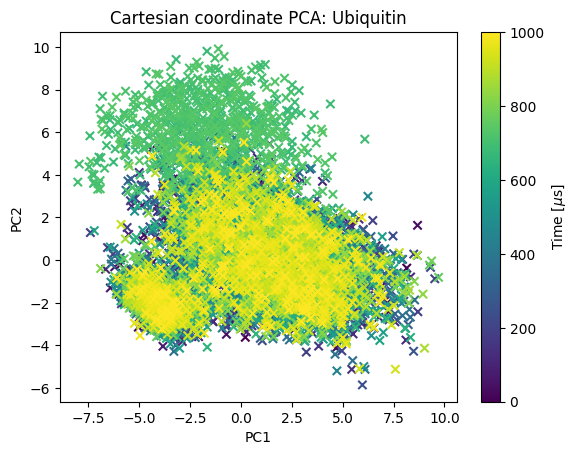

In [20]:
#We Can plot eaceh frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]')

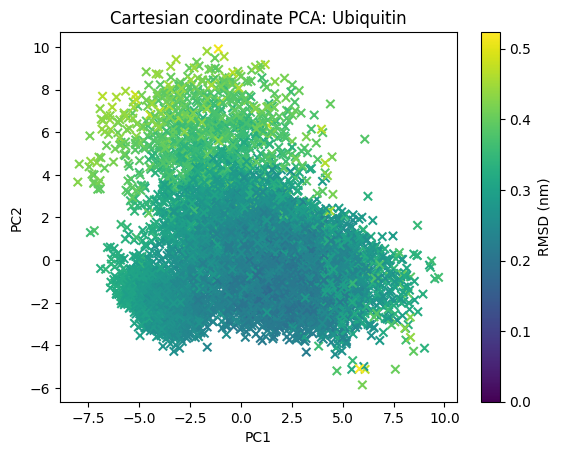

In [21]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

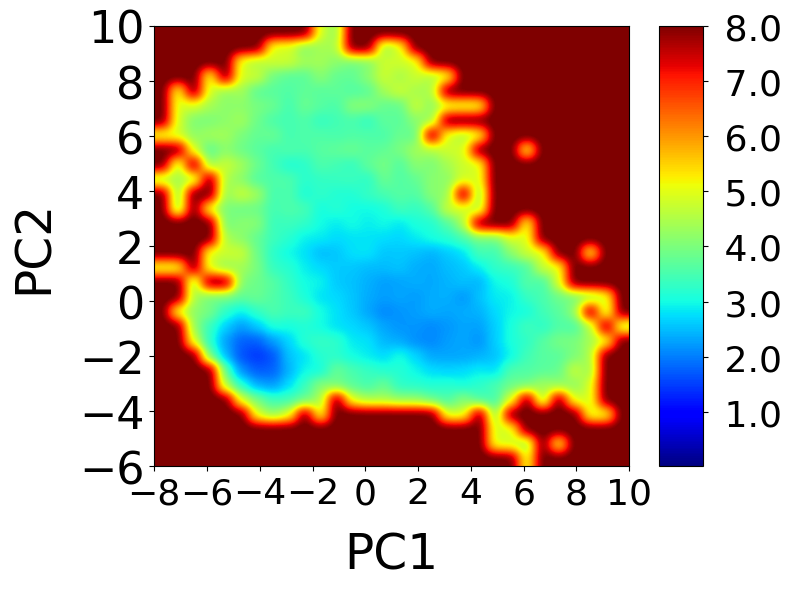

In [22]:
###Lets Make a Pretty Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -8, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-8,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

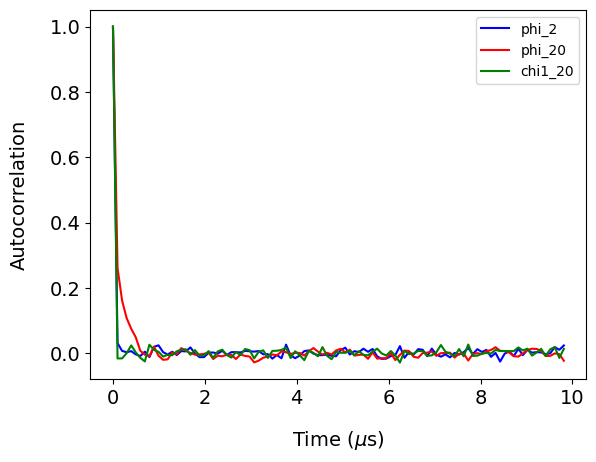

In [336]:
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    x=np.radians(x)
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    #corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]

    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(100)
#C1C2bondlength[:,0]
phi2_acf=autocorr1(dihedral_dict['phi'][2],lags)
phi20_acf=autocorr1(dihedral_dict['phi'][20],lags)
chi20_acf=autocorr1(dihedral_dict['chi1'][20],lags)

plt.plot(time[lags],phi2_acf,color='b',label='phi_2')
plt.plot(time[lags],phi20_acf,color='r',label='phi_20')
plt.plot(time[lags],chi20_acf,color='g',label='chi1_20')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

In [355]:
#Lets Make a Contact Map
def contact_map_maker(trj):
    contact_maps = []
    contact_distances = []
    for i in tqdm(range(1, 76)):
        contact_map = []
        contact_distance = []
        for j in range(1, 76):
            if i == j:
                contacts = 0
            else:
                dist = md.compute_contacts(trj, [[i, j]])
                array = np.asarray(dist[0]).astype(float)
                distance = np.average(array)
                contact_distance.append(distance)
                contact = np.where(array < 0.5, 1, 0)
                contacts = np.average(contact)
            contact_map.append(contacts)
        contact_maps.append(contact_map)
        contact_distances.append(contact_distance)
    final_map = np.asarray(contact_maps).astype(float)
    final_distance = np.asarray(contact_distances).astype(float)

    return final_map



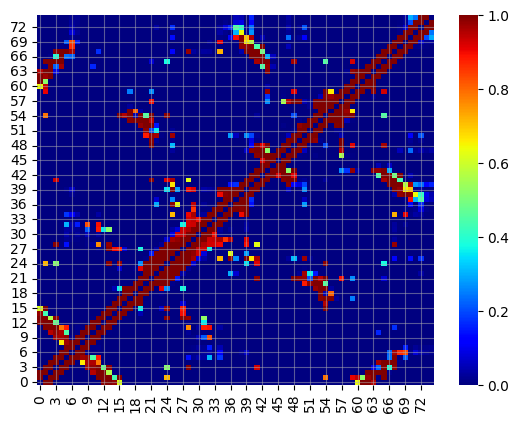

In [25]:
final_map=contact_map_maker(trj)
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)


Lets think about some fun things we can do with this trajectory.  

Rubric (Completing the bolded tasks and attempting some additional tasks puts an assignment in the ~"P - B/B+" range, attempting and completing some additional more advanced tasks will earn a ~"HP - A/A-").  Very parital or incomplete attempts for the bolded questiosn is in the ~"LP / B-/C+"

Ideas:

**1.) Determine what is structural different about the "minor state" populated between 650-750us.  Can you make a visualization of the two states?** 

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**

  More Advanced:
  
  2a) Can you calculate/ fit the correlation times? 
  
  2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold? 

3)Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles?  Are there torsion angles with large differences in their correlation times between states?  Can you provide trajectory snapshots that explain why?

**4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. 

5) Make a 2D map showing the populations of hydrogen bonds between different residues.

6) Compare the contact maps, dihedral correlations, and hydrogen bond populations between the major and minor states.

7) Compare the contact maps, dihedral correlations, and hydrogen bond populations for different subsets of PC space (ie PC1 is on the intevral [lower1,upper1] and PC2 is on the invertval [lower2,upper2]

7) Compute an visualize all-to-all RMSD calculation of the frames of this trajectory.  

8) Cluster the conformations of the trajectory in some way.  Perhaps consider using the all-to-all rmsd distances, or the the values of PCs.  (Consult https://mdtraj.org/1.9.4/examples/clustering.html or https://mdtraj.org/1.9.4/examples/centroids.html for examples)


9) Visualize the most populated clusters from your clustering analysis

**1.) Determine what is structural different about the "minor state" populated between 650-750us.  Can you make a visualization of the two states?** 

The structural difference between the minor state and the native state is the unfolding of the helix making up
residues 25-42 and the beta sheet making up residues 5-15. The green structure is the Xray structure


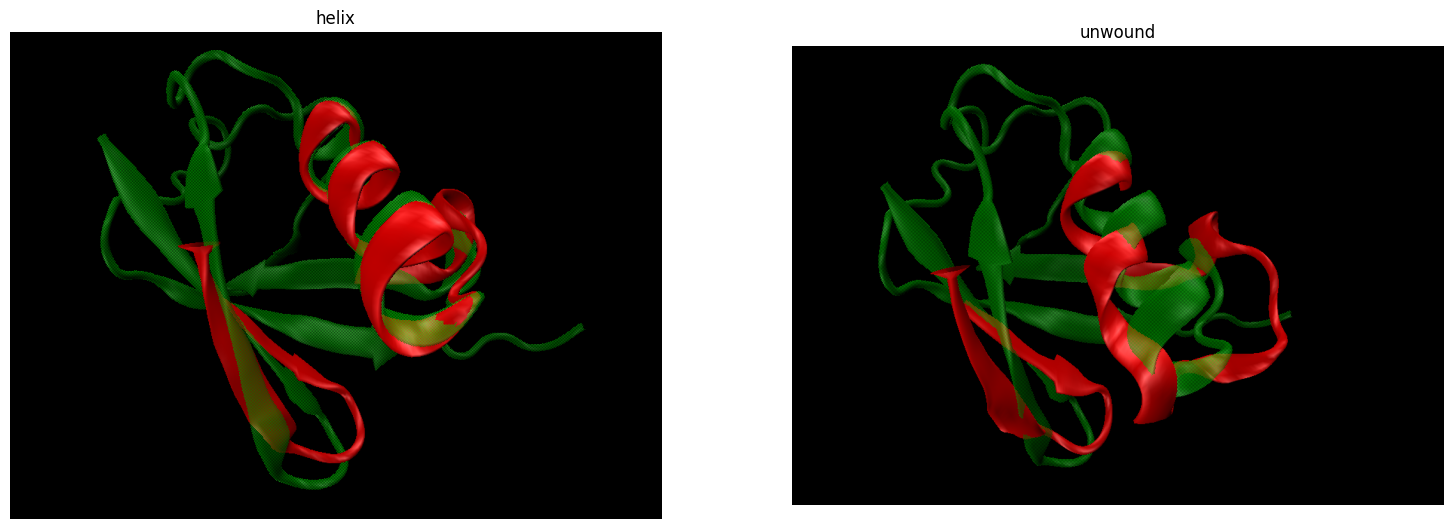

In [92]:
print("The structural difference between the minor state and the native state is the unfolding of the helix making up")
print("residues 25-42 and the beta sheet making up residues 5-15. The green structure is the Xray structure")

native_state=np.asarray(Image.open('/ipynb_files/CHEM96_06/Project_3/photos/native.png'))
unwound_helix=np.asarray(Image.open('/ipynb_files/CHEM96_06/Project_3/photos/unwound.png'))

fig, axs = plt.subplots(1,2)
fig.set_size_inches(18.5,10)
axs[0].axis('off')
axs[1].axis('off')
axs[0].title.set_text('helix')
axs[1].title.set_text('unwound')
axs[0].imshow(native_state)
axs[1].imshow(unwound_helix)

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**

2a) Can you calculate/ fit the correlation times? 
  
  2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold? 

  0%|                                                                                           | 0/72 [00:00<?, ?it/s]C:\Users\Caleb Liu\AppData\Local\Temp\ipykernel_115368\847872089.py:6: RuntimeWarning: overflow encountered in exp
  return np.exp(-x/tau)
100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:21<00:00,  3.39it/s]


phi with long correlation time: [10, 31, 33, 35, 40, 60]
psi with long correlation time: [8, 9, 13, 30, 31, 32, 33, 34, 35, 36, 39, 51, 59]
chi1 with long correlation time: []
chi2 with long correlation time: [59]
which residue would you like to plot? enter 0 to exit (the snapshots are for residue 59)59
correlation times for selected residue: [array([0.04448893]), array([3.45881876]), array([0.03213463]), array([1.08352824])]


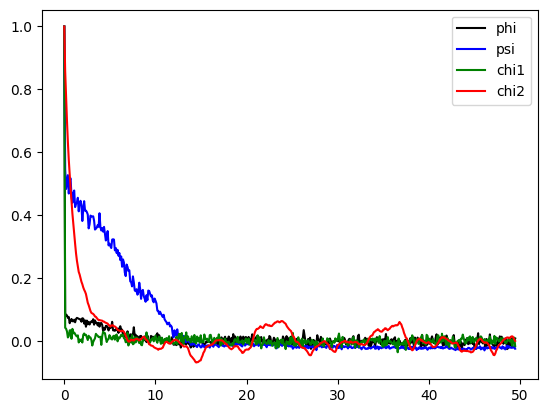

which residue would you like to plot? enter 0 to exit (the snapshots are for residue 59)0


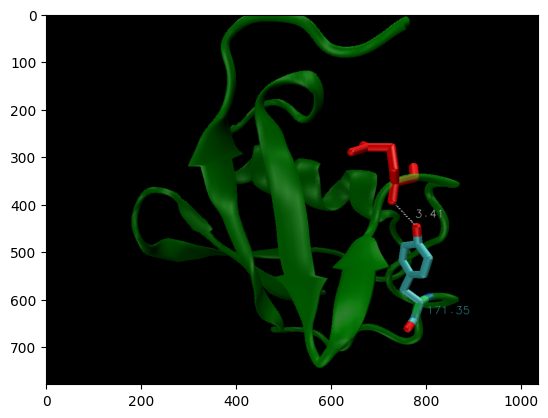

Here, the hydrogen bonding between the tyrosine hydroxyl on residue 59 and the backbone nitrogen on the glutamic acid
of residue 51 holds the position of the residue, and thus the chi2 and psi angles relatively constant, leading to longer correlation times.


<Figure size 640x480 with 0 Axes>

In [338]:
#I will code 2a) and 2b) first as it will effectively make 2) easier

from scipy.optimize import curve_fit

def exponential(x,tau):
    return np.exp(-x/tau)

def fit_exp(time, acf):
    popt = curve_fit(exponential, time, acf)
    fit_tau = popt[0]
    return fit_tau

#Defining time (1ms over n_frames)
time=np.linspace(0,1000,trj.n_frames)
lags=range(500)

cutoff = 0.4
phi_t_above_cutoff=[]
psi_t_above_cutoff=[]
chi1_t_above_cutoff=[]
chi2_t_above_cutoff=[]
t_by_residue_index=[]
for i in tqdm(range(72)): ##first two and last two don't have entries in dihedral_dict
    res_t=[0,0,0,0]
    
    if i+2 in dihedral_dict['phi']:
        res_t[0]=fit_exp(time[lags],autocorr1(dihedral_dict['phi'][i+2],lags))
    if i+2 in dihedral_dict['psi']:
        res_t[1]=fit_exp(time[lags],autocorr1(dihedral_dict['psi'][i+2],lags))
    if i+2 in dihedral_dict['chi1']:
        res_t[2]=fit_exp(time[lags],autocorr1(dihedral_dict['chi1'][i+2],lags))
    if i+2 in dihedral_dict['chi2']:
        res_t[3]=fit_exp(time[lags],autocorr1(dihedral_dict['chi2'][i+2],lags))
    
    #using the predetermined autocorrelation function,
    if res_t[0] > cutoff:
        phi_t_above_cutoff.append(i+2)
    if res_t[1] > cutoff:
        psi_t_above_cutoff.append(i+2)
    if res_t[2] > cutoff:
        chi1_t_above_cutoff.append(i+2)
    if res_t[3] > cutoff:
        chi2_t_above_cutoff.append(i+2)
    
    t_by_residue_index.append(res_t)
    
# x = np.linspace(0,1,100)
# exp = exponential(x,fit_exp(time[lags],phi2_acf))
# plt.plot(time[lags],phi2_acf)
# plt.plot(x,exp)
# print(fit_exp(time[lags],phi2_acf))

print("phi with long correlation time:", phi_t_above_cutoff)
print("psi with long correlation time:", psi_t_above_cutoff)
print("chi1 with long correlation time:", chi1_t_above_cutoff)
print("chi2 with long correlation time:", chi2_t_above_cutoff)


#We notice that residue 59 has long correlation times
while True:
    ip = int(input("which residue would you like to plot? enter 0 to exit (the snapshots are for residue 59)"))
    
    if ip == 0:
        break
    
    phi_acf=autocorr1(dihedral_dict['phi'][ip],lags)
    psi_acf=autocorr1(dihedral_dict['psi'][ip],lags)
    if ip in dihedral_dict['chi1']:
        chi1_acf=autocorr1(dihedral_dict['chi1'][ip],lags)
    if ip in dihedral_dict['chi2']:
        chi2_acf=autocorr1(dihedral_dict['chi2'][ip],lags)
    
    print("correlation times for selected residue:", t_by_residue_index[ip-2])
    
    plt.plot(time[lags],phi_acf,color='k',label='phi')
    plt.plot(time[lags],psi_acf,color='b',label='psi')
    if ip in dihedral_dict['chi1']:
        plt.plot(time[lags],chi1_acf,color='g',label='chi1')
    if ip in dihedral_dict['chi2']:
        plt.plot(time[lags],chi2_acf,color='r',label='chi2')
    plt.legend()
    plt.show()
    plt.clf()
    
snapshot=np.asarray(Image.open('/ipynb_files/CHEM96_06/Project_3/photos/res59.png'))

plt.imshow(snapshot)
plt.show()
plt.clf()

print("Here, the hydrogen bonding between the tyrosine hydroxyl on residue 59 and the backbone nitrogen on the glutamic acid")
print("of residue 51 holds the position of the residue, and thus the chi2 angles relatively constant, leading to longer correlation times.")
print("for an analysis of the psi angle, see below.")

3)Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles?  Are there torsion angles with large differences in their correlation times between states?  Can you provide trajectory snapshots that explain why?


In [341]:
#We define a function to plot only part of the trajectory

def plot_phipsi_indices(res, indices):
    plt.hist2d(dihedral_dict['phi'][res][indices],dihedral_dict['psi'][res][indices],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
    plt.xlabel('$\phi$', size=18)
    plt.ylabel('$\psi$', size=18)
    plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
    plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
    plt.tick_params(labelsize=18)
    plt.show()
    return

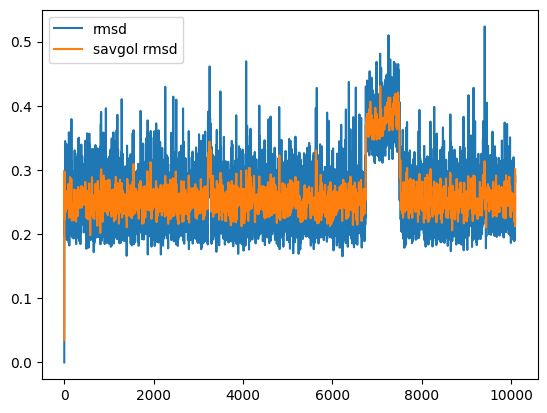

In [368]:
## First, let us quantitatively define the minor state

#The savitsky-golay filter effectively reduces the noise of the rmsd fluctuations so we may now extract the frames of the higher RMSD state
from scipy.signal import savgol_filter

rmsd = md.rmsd(trj, trj, 0)
smoothed_rmsd = savgol_filter(rmsd, 25, 5)

plt.plot(rmsd, label='rmsd')
plt.plot(smoothed_rmsd, label='savgol rmsd')
plt.legend()
plt.show()

all_frames=np.asarray([i for i in range(n_frames)])
high_rmsd_frames=np.where(smoothed_rmsd > 0.35)[0]
low_rmsd_frames=np.where(smoothed_rmsd < 0.35)[0]

first_section_indices = np.where(low_rmsd_frames < high_rmsd_frames[0])
first_section_low_rmsd=low_rmsd_frames[first_section_indices]

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:03<00:00, 18.18it/s]


phis with high deviation: [6, 18, 31, 33, 41, 43, 62, 66]
psis with high deviation: [22, 31, 32, 33, 34, 70, 72, 73]
chi1s with high deviation: [8, 11, 15, 29, 30, 31, 36, 38, 39, 40, 42, 45, 48, 67, 72]
chi2s with high deviation: [19, 32, 33, 38, 41, 42, 43, 44, 59, 61, 62, 71]
which residue would you like to plot? enter 0 to exit. Snapshots are for residue 3131
correlation times for selected residue: [array([5.900921]), array([11.1349329]), array([0.00310993]), array([0.01833617])]


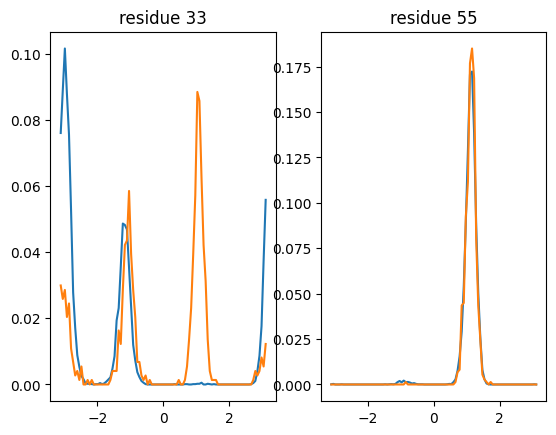

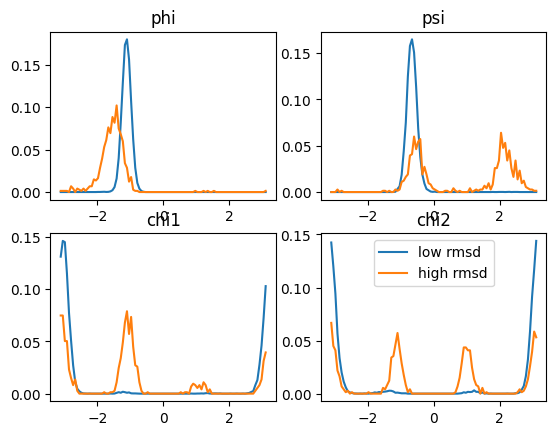

which residue would you like to plot? enter 0 to exit. Snapshots are for residue 310
Residue 31 has a large change in the distribution of backbone angles, as we can see below. This is easily attributed
To the unfolding of the helix


<Figure size 640x480 with 0 Axes>

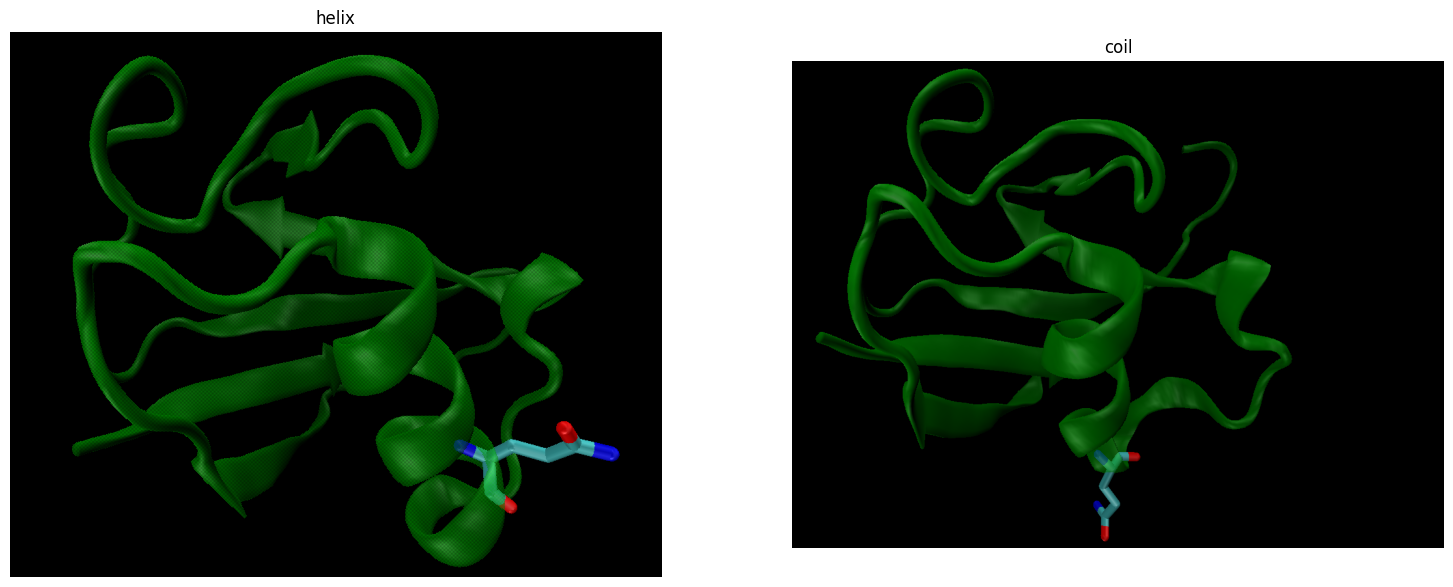

In [348]:
#now, we may plot the dihedral angles
plot, axs = plt.subplots(1,2)
counts,edges=np.histogram(dihedral_dict['chi1'][33][low_rmsd_frames], bins=100, range=(-np.pi,np.pi))
centers = edges[:-1] + np.diff(edges)/2
density=counts/(np.sum(counts))
axs[0].title.set_text('residue 33')
axs[0].plot(centers,density)
counts,edges=np.histogram(dihedral_dict['chi1'][33][high_rmsd_frames], bins=100, range=(-np.pi,np.pi))
centers2 = edges[:-1] + np.diff(edges)/2
density2=counts/(np.sum(counts))
axs[0].plot(centers2,density2)
counts,edges=np.histogram(dihedral_dict['chi1'][55][low_rmsd_frames], bins=100, range=(-np.pi,np.pi))
centers = edges[:-1] + np.diff(edges)/2
density=counts/(np.sum(counts))
axs[1].title.set_text('residue 55')
axs[1].plot(centers,density)
counts,edges=np.histogram(dihedral_dict['chi1'][55][high_rmsd_frames], bins=100, range=(-np.pi,np.pi))
centers2 = edges[:-1] + np.diff(edges)/2
density2=counts/(np.sum(counts))
axs[1].plot(centers2,density2)

def gauss(x,a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))

def fit_gaussian_for_means(centers,density): #using the gaussian function defined in class
    param, cov = curve_fit(gauss,centers,density,bounds=(-6,7),maxfev=5000)
    return param[1],param[2]

def pdf(params):
    centers = params[1][:-1] + np.diff(params[1])/2
    density = params[0]/(np.sum(params[0]))

    return centers, density

#Effectively, we see that the angles are all over the place for certain residues in the minor state. Let us characterize this

high_deviation_phis=[]
high_deviation_psis=[]
high_deviation_chi1s=[]
high_deviation_chi2s=[]

mean_cutoff=0.1
var_cutoff=0.5

for i in tqdm(range(72)): 
    #we will model these histograms as gaussians and compare means and standard deviations
    #comparing phis
    if i+2 in dihedral_dict['phi']:
        center1,density1=pdf(np.histogram(dihedral_dict['phi'][i+2][low_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        center2,density2=pdf(np.histogram(dihedral_dict['phi'][i+2][high_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        mean1, var1 = fit_gaussian_for_means(center1,density1)
        mean2, var2 = fit_gaussian_for_means(center2,density2)
        
        if (np.abs(mean1-mean2) > mean_cutoff) & (np.abs(var1-var2) > var_cutoff):
            high_deviation_phis.append(i+2)
        
    if i+2 in dihedral_dict['psi']:
        center1,density1=pdf(np.histogram(dihedral_dict['psi'][i+2][low_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        center2,density2=pdf(np.histogram(dihedral_dict['psi'][i+2][high_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        mean1, var1 = fit_gaussian_for_means(center1,density1)
        mean2, var2 = fit_gaussian_for_means(center2,density2)
        
        if (np.abs(mean1-mean2) > mean_cutoff) & (np.abs(var1-var2) > var_cutoff):
            high_deviation_psis.append(i+2)
            
    if i+2 in dihedral_dict['chi1']:
        center1,density1=pdf(np.histogram(dihedral_dict['chi1'][i+2][low_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        center2,density2=pdf(np.histogram(dihedral_dict['chi1'][i+2][high_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        mean1, var1 = fit_gaussian_for_means(center1,density1)
        mean2, var2 = fit_gaussian_for_means(center2,density2)
        
        if (np.abs(mean1-mean2) > mean_cutoff) & (np.abs(var1-var2) > var_cutoff):
            high_deviation_chi1s.append(i+2)
    if i+2 in dihedral_dict['chi2']:
        center1,density1=pdf(np.histogram(dihedral_dict['chi2'][i+2][low_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        center2,density2=pdf(np.histogram(dihedral_dict['chi2'][i+2][high_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        mean1, var1 = fit_gaussian_for_means(center1,density1)
        mean2, var2 = fit_gaussian_for_means(center2,density2)
        
        if (np.abs(mean1-mean2) > mean_cutoff) & (np.abs(var1-var2) > var_cutoff):
            high_deviation_chi2s.append(i+2)
            
print("phis with high deviation:", high_deviation_phis)
print("psis with high deviation:", high_deviation_psis)
print("chi1s with high deviation:", high_deviation_chi1s)
print("chi2s with high deviation:", high_deviation_chi2s)

while True:
    ip = int(input("which residue would you like to plot? enter 0 to exit. Snapshots are for residue 31"))
    
    if ip == 0:
        break
    
    print("correlation times for selected residue:", t_by_residue_index[ip-2])
    
    plot, axs = plt.subplots(2,2)
    if i+2 in dihedral_dict['phi']:
        center1,density1=pdf(np.histogram(dihedral_dict['phi'][ip][low_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        center2,density2=pdf(np.histogram(dihedral_dict['phi'][ip][high_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        axs[0,0].title.set_text('phi')
        axs[0,0].plot(center1,density1)
        axs[0,0].plot(center2,density2)
    if i+2 in dihedral_dict['psi']:
        center1,density1=pdf(np.histogram(dihedral_dict['psi'][ip][low_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        center2,density2=pdf(np.histogram(dihedral_dict['psi'][ip][high_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        axs[0,1].title.set_text('psi')
        axs[0,1].plot(center1,density1)
        axs[0,1].plot(center2,density2)
    if ip in dihedral_dict['chi1']:
        center1,density1=pdf(np.histogram(dihedral_dict['chi1'][ip][low_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        center2,density2=pdf(np.histogram(dihedral_dict['chi1'][ip][high_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        axs[1,0].title.set_text('chi1')
        axs[1,0].plot(center1,density1)
        axs[1,0].plot(center2,density2)
    if ip in dihedral_dict['chi2']:
        center1,density1=pdf(np.histogram(dihedral_dict['chi2'][ip][low_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        center2,density2=pdf(np.histogram(dihedral_dict['chi2'][ip][high_rmsd_frames], bins=100, range=(-np.pi,np.pi)))
        axs[1,1].title.set_text('chi2')
        axs[1,1].plot(center1,density1, label='low rmsd')
        axs[1,1].plot(center2,density2, label='high rmsd')
    
    plt.legend()
    plt.show()
    plt.clf()

print("Residue 31 has a large change in the distribution of backbone angles, as we can see below. This is easily attributed")
print("To the unfolding of the helix")

basin_helix=np.asarray(Image.open('/ipynb_files/CHEM96_06/Project_3/photos/res39_folded.png'))
basin_coil=np.asarray(Image.open('/ipynb_files/CHEM96_06/Project_3/photos/res39_unfolded.png'))

fig, axs = plt.subplots(1,2)
fig.set_size_inches(18.5,10)
axs[0].axis('off')
axs[1].axis('off')
axs[0].title.set_text('helix')
axs[1].title.set_text('coil')
axs[0].imshow(basin_helix)
axs[1].imshow(basin_coil)


range(0, 80)


  0%|                                                                                           | 0/72 [00:00<?, ?it/s]C:\Users\Caleb Liu\AppData\Local\Temp\ipykernel_115368\847872089.py:6: RuntimeWarning: overflow encountered in exp
  return np.exp(-x/tau)
100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:05<00:00, 13.57it/s]


phis with high deviation: [8, 10, 14, 33, 35, 36, 40, 53, 60]
psis with high deviation: [5, 8, 9, 11, 12, 13, 30, 31, 32, 34, 35, 36, 38, 39, 51, 52, 59]
chi1s with high deviation: [7, 9, 13, 30, 33, 36]
chi2s with high deviation: [19, 32, 33, 38, 41, 42, 43, 44, 59, 61, 62, 71, 59, 59, 59]
which residue would you like to plot? enter 0 to exit (analysis is for residue 59)59


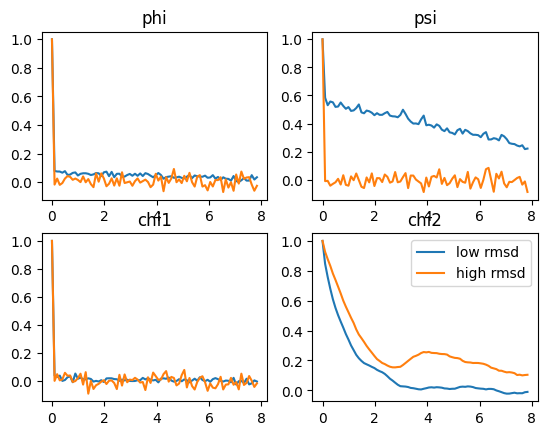

which residue would you like to plot? enter 0 to exit (analysis is for residue 59)0
We notice that there are two states occupied by the phi angle from the time series. Snapshots seen below
It appears that these arise from the straightening of a coil
we may thus attribute the long correlation time of residue 59's psi angle to sampling two basins, whereas
for the excited state, only one basin is sampled.


<Figure size 640x480 with 0 Axes>

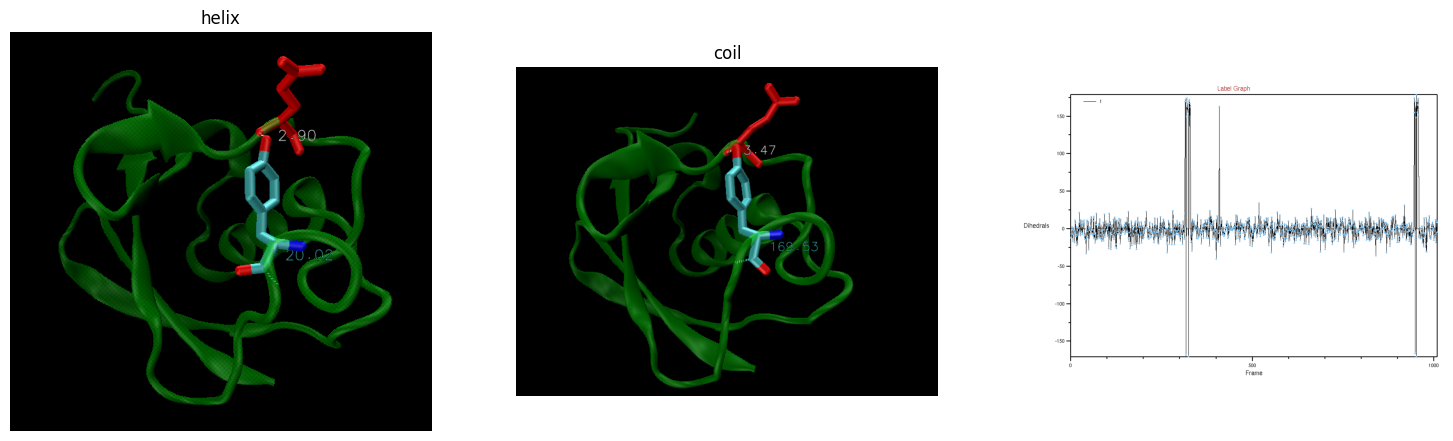

here is the ground state basins


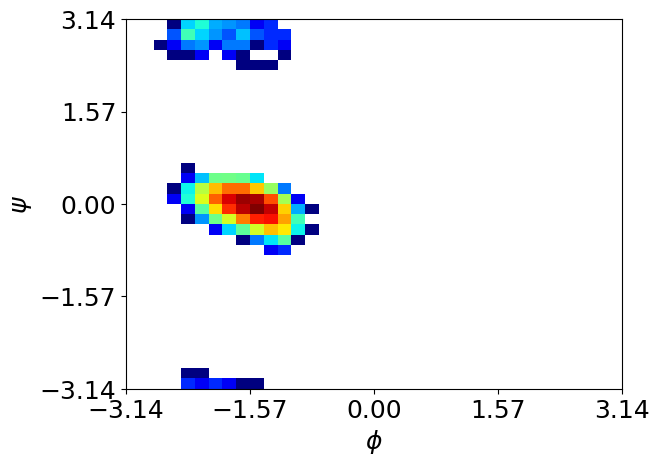

here is the excited state basins


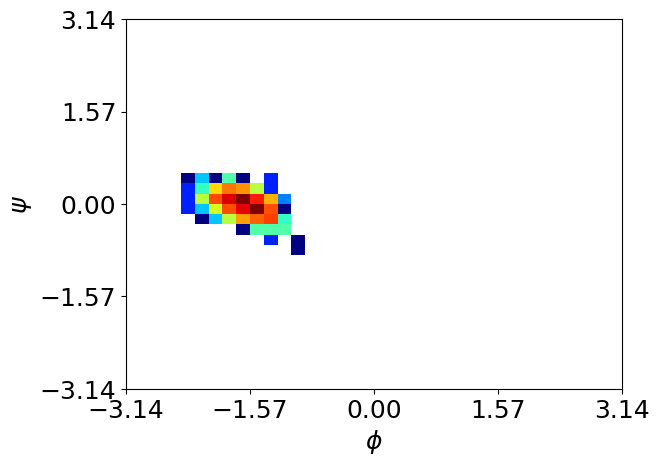

In [351]:
#Now, let us do the same for correlation times

time=np.linspace(0,1000,trj.n_frames)
lags=range(80)

print(lags)


high_deviation_phis=[]
high_deviation_psis=[]
high_deviation_chi1s=[]

# tau1=autocorr1(dihedral_dict['phi'][i+2][low_rmsd_frames],lags)
# tau2=autocorr1(dihedral_dict['phi'][i+2][high_rmsd_frames],lags)
# print(tau1)
# print(tau2)
# plt.plot(time[lags],tau1,color='k',label='phi')
# plt.plot(time[lags],tau2,color='b',label='psi')

cutoff = 0.1
for i in tqdm(range(72)):
    if i+2 in dihedral_dict['phi']:
        tau1=fit_exp(time[lags],autocorr1(dihedral_dict['phi'][i+2][first_section_low_rmsd],lags))
        tau2=fit_exp(time[lags],autocorr1(dihedral_dict['phi'][i+2][high_rmsd_frames],lags))
        if np.abs(tau1-tau2) > cutoff:
            high_deviation_phis.append(i+2)
    if i+2 in dihedral_dict['psi']:
        tau1=fit_exp(time[lags],autocorr1(dihedral_dict['psi'][i+2][first_section_low_rmsd],lags))
        tau2=fit_exp(time[lags],autocorr1(dihedral_dict['psi'][i+2][high_rmsd_frames],lags))
        if np.abs(tau1-tau2) > cutoff:
            high_deviation_psis.append(i+2)
    if i+2 in dihedral_dict['chi1']:
        tau1=fit_exp(time[lags],autocorr1(dihedral_dict['chi1'][i+2][first_section_low_rmsd],lags))
        tau2=fit_exp(time[lags],autocorr1(dihedral_dict['chi1'][i+2][high_rmsd_frames],lags))
        if np.abs(tau1-tau2) > cutoff:
            high_deviation_chi1s.append(i+2)
    if i+2 in dihedral_dict['chi2']:
        tau1=fit_exp(time[lags],autocorr1(dihedral_dict['chi2'][i+2][first_section_low_rmsd],lags))
        tau2=fit_exp(time[lags],autocorr1(dihedral_dict['chi2'][i+2][high_rmsd_frames],lags))
        if np.abs(tau1-tau2) > cutoff:
            high_deviation_chi2s.append(i+2)

print("phis with high deviation:", high_deviation_phis)
print("psis with high deviation:", high_deviation_psis)
print("chi1s with high deviation:", high_deviation_chi1s)
print("chi2s with high deviation:", high_deviation_chi2s)

while True:
    ip = int(input("which residue would you like to plot? enter 0 to exit (analysis is for residue 59)"))
    
    if ip == 0:
        break
    
    plot, axs = plt.subplots(2,2)
    if i+2 in dihedral_dict['phi']:
        acf1=autocorr1(dihedral_dict['phi'][ip][first_section_low_rmsd],lags)
        acf2=autocorr1(dihedral_dict['phi'][ip][high_rmsd_frames],lags)
        axs[0,0].title.set_text('phi')
        axs[0,0].plot(time[lags],acf1)
        axs[0,0].plot(time[lags],acf2)
    if i+2 in dihedral_dict['psi']:
        acf1=autocorr1(dihedral_dict['psi'][ip][first_section_low_rmsd],lags)
        acf2=autocorr1(dihedral_dict['psi'][ip][high_rmsd_frames],lags)
        axs[0,1].title.set_text('psi')
        axs[0,1].plot(time[lags],acf1)
        axs[0,1].plot(time[lags],acf2)
    if ip in dihedral_dict['chi1']:
        acf1=autocorr1(dihedral_dict['chi1'][ip][first_section_low_rmsd],lags)
        acf2=autocorr1(dihedral_dict['chi1'][ip][high_rmsd_frames],lags)
        axs[1,0].title.set_text('chi1')
        axs[1,0].plot(time[lags],acf1)
        axs[1,0].plot(time[lags],acf2)
    if ip in dihedral_dict['chi2']:
        acf1=autocorr1(dihedral_dict['chi2'][ip][first_section_low_rmsd],lags)
        acf2=autocorr1(dihedral_dict['chi2'][ip][high_rmsd_frames],lags)
        axs[1,1].title.set_text('chi2')
        axs[1,1].plot(time[lags],acf1, label='low rmsd')
        axs[1,1].plot(time[lags],acf2, label='high rmsd')
    
    plt.legend()
    plt.show()
    plt.clf()
    
print("We notice that there are two states occupied by the phi angle from the time series. Snapshots seen below")
print("It appears that these arise from the straightening of a coil")
print("we may thus attribute the long correlation time of residue 59's psi angle to sampling two basins, whereas")
print("for the excited state, only one basin is sampled.")

timeseries=np.asarray(Image.open('/ipynb_files/CHEM96_06/Project_3/photos/res59_phi_time_series.png'))
basin_helix=np.asarray(Image.open('/ipynb_files/CHEM96_06/Project_3/photos/res59_helix_basin.png'))
basin_coil=np.asarray(Image.open('/ipynb_files/CHEM96_06/Project_3/photos/res59_straight_basin.png'))

fig, axs = plt.subplots(1,3)
fig.set_size_inches(18.5,10)
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[0].title.set_text('helix')
axs[1].title.set_text('coil')
axs[0].imshow(basin_helix)
axs[1].imshow(basin_coil)
axs[2].imshow(timeseries)

plt.show()
plt.clf()

print("here is the ground state basins")
plot_phipsi_indices(59, first_section_low_rmsd)
print("here is the excited state basins")
plot_phipsi_indices(59, high_rmsd_frames)

**4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. 


[    0     1     2 ... 10085 10086 10087]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.56it/s]


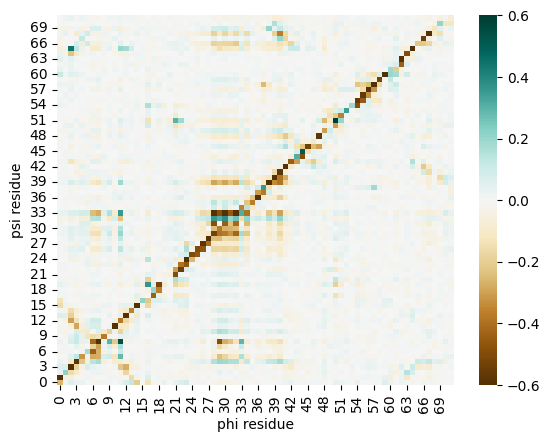

<Figure size 640x480 with 0 Axes>

In [381]:
print(all_frames)
def calculate_rho(res1, res2, frames):
    phis = np.radians(np.asarray(dihedral_dict['phi'][res1][frames]))
    psis = np.radians(np.asarray(dihedral_dict['psi'][res2][frames]))
    
    avg_phi = np.arctan2(np.sum(np.sin(phis)),np.sum(np.cos(phis)))
    avg_psi = np.arctan2(np.sum(np.sin(psis)),np.sum(np.cos(psis)))
    
    numerator = np.sum(np.sin(phis-avg_phi)*np.sin(psis-avg_psi))
    denominator = np.sqrt(np.sum(np.sin(phis-avg_phi)**2)*np.sum(np.sin(psis-avg_psi)**2))
    
    return numerator/denominator

def plot_rho(frames):
    total_map=[]
    for i in tqdm(range(2,74)):
        res_map=[]
        for j in range(2,74):
            res_map.append(calculate_rho(i,j,frames))

        total_map.append(res_map)

    final_map=np.asarray(total_map).astype(float)
    ax=sns.heatmap(final_map,vmin=-0.6, vmax=0.6,cmap='BrBG')
    ax.invert_yaxis()
    ax.set(xlabel='phi residue',ylabel='psi residue')
    plt.show()
    plt.clf()
    
plot_rho(all_frames)

5) Make a 2D map showing the populations of hydrogen bonds between different residues.


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:48<00:00,  1.56it/s]


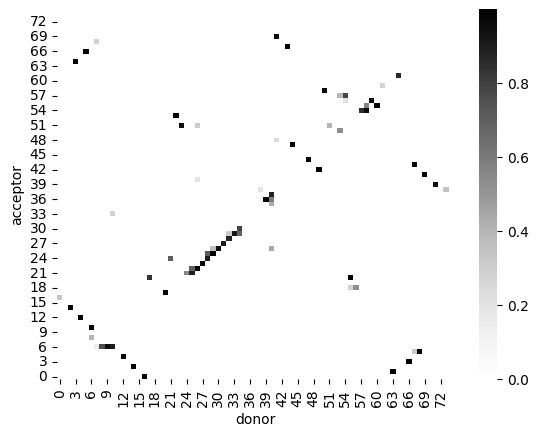

<Figure size 640x480 with 0 Axes>

In [399]:
#the hbond according to baker-hubbard exists when theta_DHA > 120 and r_HA < 2.5 A for at least 10% of frames. We can narrow this down
# donor_id=[]
# acceptor_id=[]
# for hbond in hbonds:
#     donor_id.append(top.atom(hbond[0]).residue.resSeq)
#     acceptor_id.append(top.atom(hbond[2]).residue.resSeq)

# total_map=[]
# for j in tqdm(range(1,76)):
#     res_map=[]
#     for i in range(1,76):
#         num_hbonds=0
#         for k in range(len(donor_id)):
#             if (donor_id[k] == i) & (acceptor_id[k] == j):
#                 num_hbonds += 1
        
#         res_map.append(num_hbonds)
        
#     total_map.append(res_map)
def map_hbonds(trj):
    
    donor_id=[]
    acceptor_id=[]
    for hbond in hbonds:
        donor_id.append(top.atom(hbond[0]).residue.resSeq)
        acceptor_id.append(top.atom(hbond[2]).residue.resSeq)

    total_map=[]
    for j in tqdm(range(1,76)):
        res_map=[]
        for i in range(1,76):
            num_hbonds=0
            hbonds_indices = []
            for k in range(len(donor_id)):
                if (donor_id[k] == i) & (acceptor_id[k] == j):
                    hbonds_indices.append(k)
                    num_hbonds += 1

            if num_hbonds == 0:
                res_map.append(0)
            else:
                total_hbonded_frames=0
                for k in hbonds_indices:
                    angles = np.rad2deg(md.compute_angles(trj,[hbonds[k]]))
                    distances = md.compute_distances(trj,[[hbonds[k][1],hbonds[k][2]]])
                    angle_frame_indices=np.where(angles > 120)[0]
                    angle_frames = all_frames[angle_frame_indices]
                    distance_frame_indices = np.where(distances < 2.5)[0]
                    distance_frames = all_frames[distance_frame_indices]

                    hbond_frames = np.intersect1d(angle_frames,distance_frames)

                    total_hbonded_frames+=len(hbond_frames)

                res_map.append(total_hbonded_frames/(num_hbonds*n_frames))
        total_map.append(res_map)
    
    return total_map

def plot_hbonds(total_map):
    final_map=np.asarray(total_map).astype(float)
    ax=sns.heatmap(final_map,cmap='Greys')
    ax.invert_yaxis()
    ax.set(xlabel='donor',ylabel='acceptor')
    plt.show()
    plt.clf()

plot_hbonds(map_hbonds(trj))

6) Compare the contact maps, dihedral correlations, and hydrogen bond populations between the major and minor states.


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 48.05it/s]


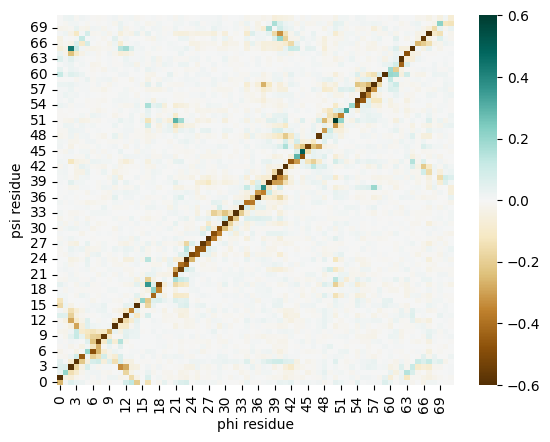

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 197.84it/s]


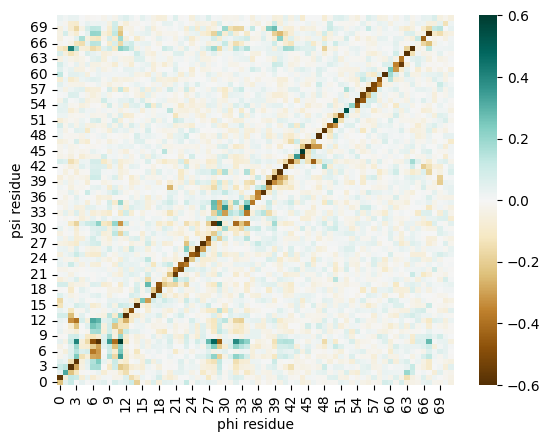

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:44<00:00,  1.68it/s]


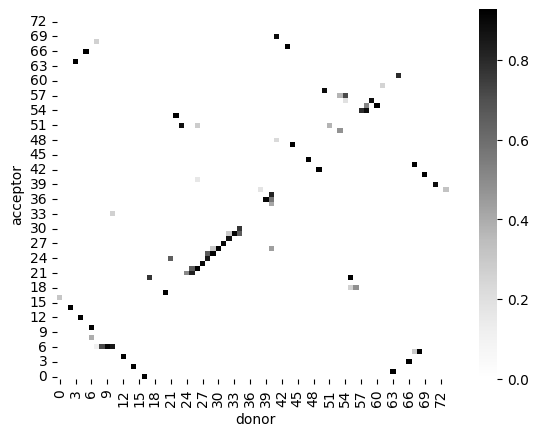

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:03<00:00, 21.13it/s]


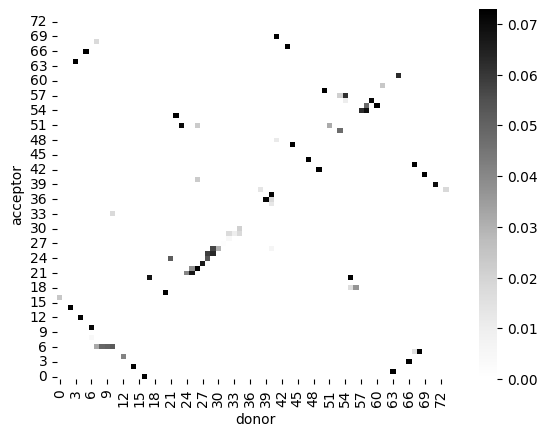

<Figure size 640x480 with 0 Axes>

In [402]:
maj_trj = trj[low_rmsd_frames]
min_trj = trj[high_rmsd_frames]

#dihedral_correlations
plot_rho(low_rmsd_frames)
plot_rho(high_rmsd_frames)

plot_hbonds(map_hbonds(maj_trj))
plot_hbonds(map_hbonds(min_trj))

In [ ]:
#contact maps:
#Didn't run these since each takes around 30 mins to run

contact_map_maker(maj_trj)
contact_map_maker(min_trj)

7) Compute an visualize all-to-all RMSD calculation of the frames of this trajectory.  

100%|████████████████████████████████████████████████████████████████████████████| 10088/10088 [03:24<00:00, 49.23it/s]


[Text(0.5, 23.52222222222222, 'time (microseconds)'),
 Text(50.722222222222214, 0.5, 'time (microseconds)')]

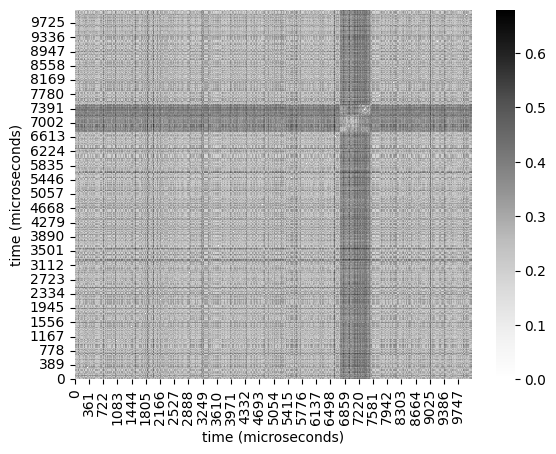

In [405]:
RMSD_map=[]
for i in tqdm(range(trj.n_frames)):
    RMSD_map.append(md.rmsd(trj, trj, i))
    
final_map=np.asarray(RMSD_map).astype(float)
ax=sns.heatmap(final_map,cmap='Greys')
ax.invert_yaxis()
ax.set(xlabel='time (microseconds)',ylabel='time (microseconds)')

8) Cluster the conformations of the trajectory in some way.  Perhaps consider using the all-to-all rmsd distances, or the the values of PCs.  (Consult https://mdtraj.org/1.9.4/examples/clustering.html or https://mdtraj.org/1.9.4/examples/centroids.html for examples)

In [412]:
state_3=[]
state_4=[]
state_5=[]
state_6=[]
state_7=[]

#clustering by mean all-to-all rmsd for a specific frame

for i in tqdm(range(trj.n_frames)):
    curr = np.mean(np.asarray(RMSD_map[i]))
    if curr < 0.3:
        state_3.append(i)
    elif curr < 0.4:
        state_4.append(i)
    elif curr < 0.5:
        state_5.append(i)
    elif curr < 0.6:
        state_6.append(i)
    else:
        state_7.append(i)
        
print("<0.3 state fraction:", len(state_3)/trj.n_frames)
print(state_6)
print("<0.4 state fraction:", len(state_4)/trj.n_frames)
print("<0.5 state fraction:", len(state_5)/trj.n_frames)
print("<0.6 state fraction:", len(state_6)/trj.n_frames)
print("all other state fraction:", len(state_7)/trj.n_frames)

100%|█████████████████████████████████████████████████████████████████████████| 10088/10088 [00:00<00:00, 49426.26it/s]

<0.3 state fraction: 0.7684377478191912
[9405]
<0.4 state fraction: 0.21818001586042823
<0.5 state fraction: 0.013283108643933386
<0.6 state fraction: 9.912767644726408e-05
all other state fraction: 0.0


9) Visualize the most populated clusters from your clustering analysis

the gray state is the backbone


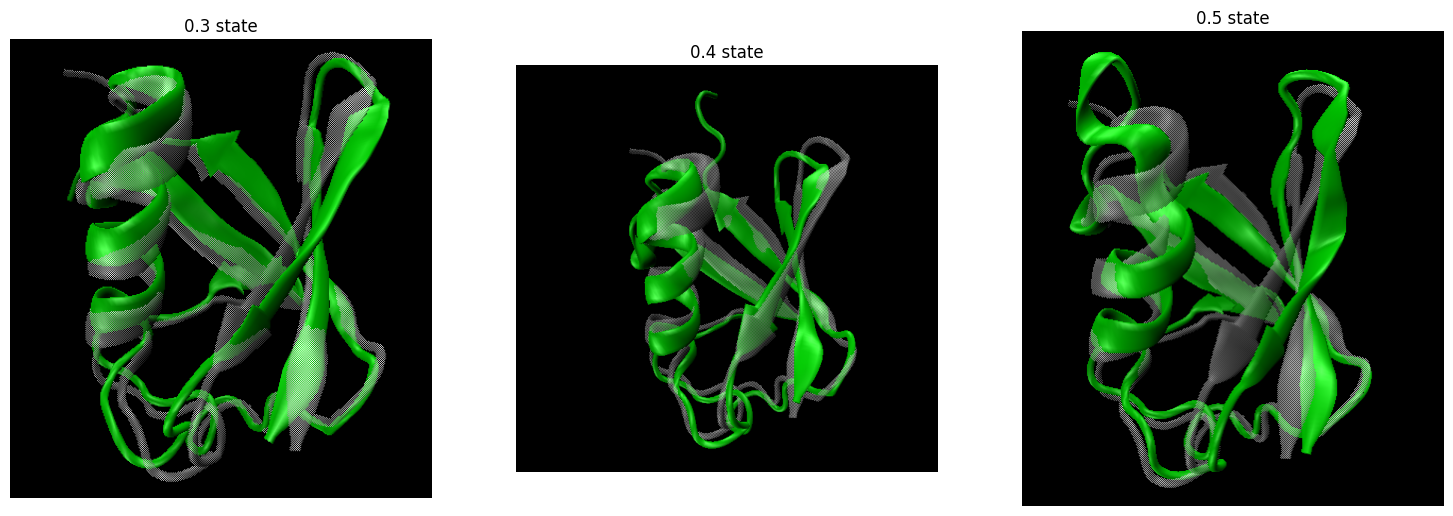

In [416]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(18.5,10)

state3=np.asarray(Image.open('/ipynb_files/CHEM96_06/Project_3/photos/state3.png'))
state4=np.asarray(Image.open('/ipynb_files/CHEM96_06/Project_3/photos/state4.png'))
state5=np.asarray(Image.open('/ipynb_files/CHEM96_06/Project_3/photos/state5.png'))

print("the gray state is the backbone")

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[0].title.set_text('0.3 state')
axs[1].title.set_text('0.4 state')
axs[2].title.set_text('0.5 state')
axs[0].imshow(state3)
axs[1].imshow(state4)
axs[2].imshow(state5)
plt.show()

Here is the equation used to calculate circular correlation coefficients for dihedral angles

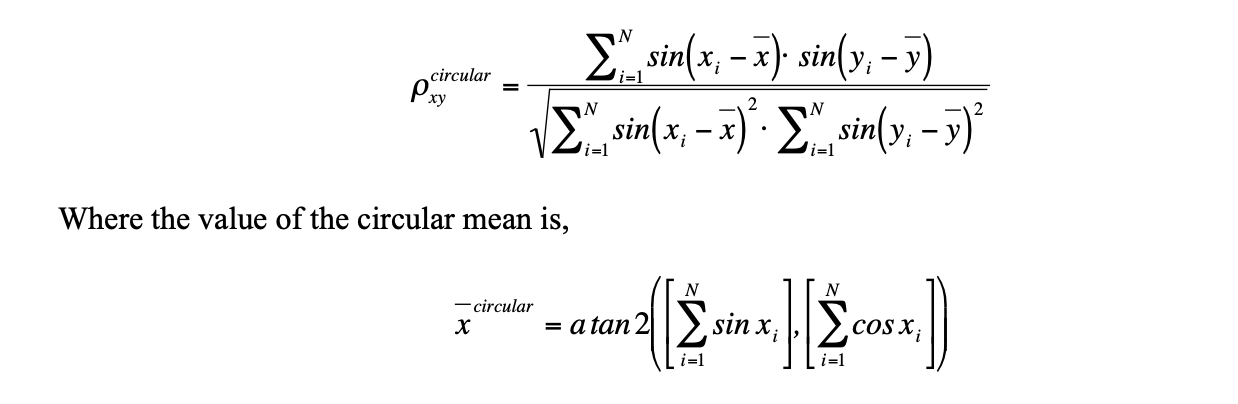


Lets calculate some correlations between dihedrals found in the paper: 


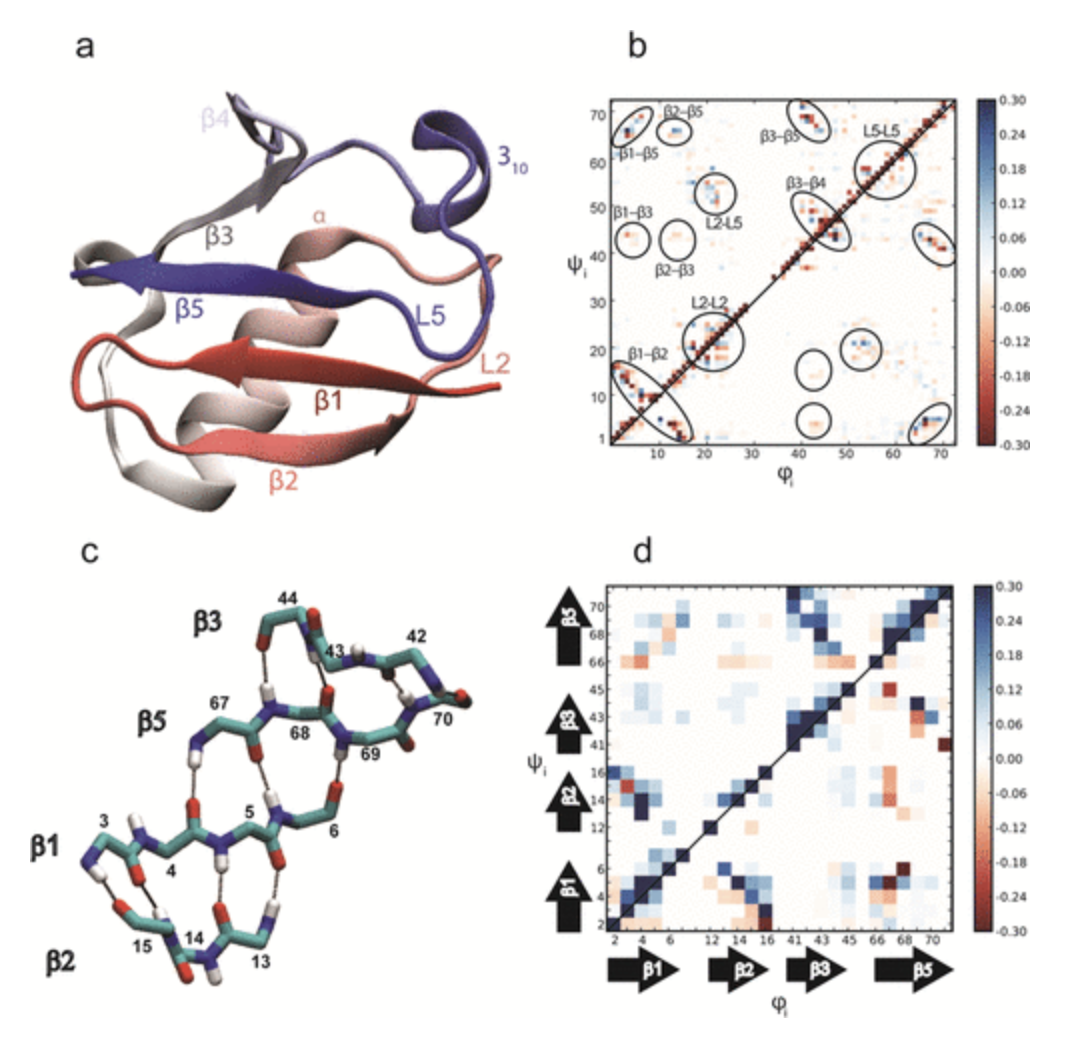